In [16]:
# Install and import needed libraries
# %pip install pandas numpy scikit-learn nltk matplotlib torch transformers datasets torch transformers torchaudio jiwer

In [17]:
# Importing libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
from torchaudio.datasets import LIBRISPEECH
from torchaudio.transforms import Resample
import joblib
import os
import torchaudio
from jiwer import wer

In [18]:
# Load the dataset
df = pd.read_csv('movie.csv')

In [19]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    text = str(text)

    # Lowercasing
    text = text.lower()
    
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizing
    words = word_tokenize(text)
    
    # Removing stopwords and non-alphabetic words
    words = [word for word in words if word.isalpha() and word not in stop_words]
    
    # Lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

In [20]:
# Remove all labels except 'reviewText' and 'overall'
df = df[['text', 'label']]

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [23]:
# Feature extraction with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Iteration 1: Train Accuracy = 0.9746875, Test Accuracy = 0.7145
Iteration 2: Train Accuracy = 0.99346875, Test Accuracy = 0.750125
Iteration 3: Train Accuracy = 0.99853125, Test Accuracy = 0.780125
Iteration 4: Train Accuracy = 0.999375, Test Accuracy = 0.799875
Iteration 5: Train Accuracy = 0.99984375, Test Accuracy = 0.807625


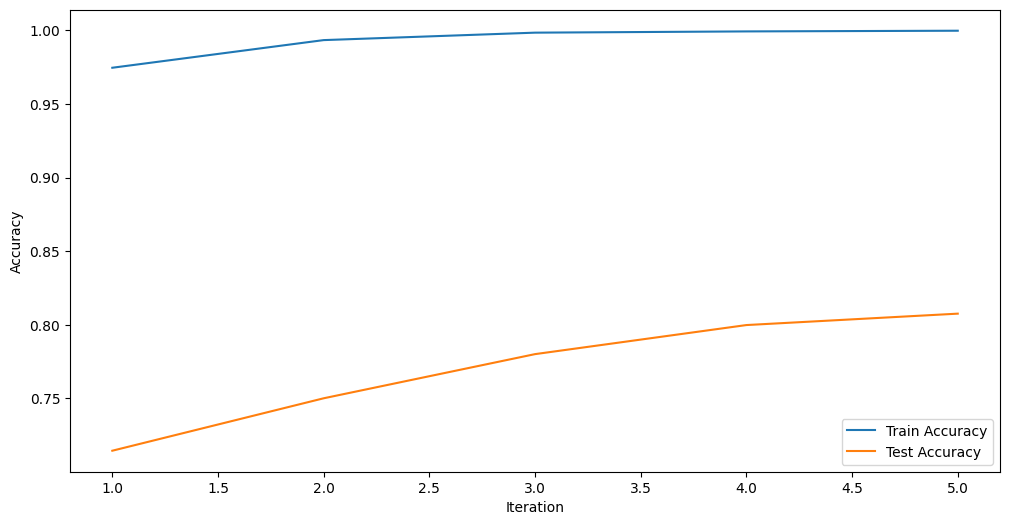

In [24]:
# Random Forest Classifier training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Plot accuracy
train_accuracies = []
test_accuracies = []
for i in range(1, 21):
    rf_model = RandomForestClassifier(n_estimators=20*i, random_state=42)
    rf_model.fit(X_train_tfidf, y_train)
    train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_tfidf))
    test_accuracy = accuracy_score(y_test, rf_model.predict(X_test_tfidf))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Iteration {i}: Train Accuracy = {train_accuracy}, Test Accuracy = {test_accuracy}")

plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 21), test_accuracies, label='Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tfidf, y_train)

best_rf_model = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best training accuracy: {grid_search.best_score_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Best parameters: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 300}
Best training accuracy: 0.8504999999999999


In [26]:
# Save the trained model
model_filename = 'sentiment_rf_model.pkl'
joblib.dump(best_rf_model, model_filename)

# Save the fitted vectorizer
vectorizer_filename = 'tfidf_vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_filename)

['tfidf_vectorizer.pkl']

In [27]:
# Fine-tuning Wav2Vec model
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model_wav2vec = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

librispeech_dev_clean = LIBRISPEECH(root='LibriSpeech',url='dev-clean' , download=False)
resampler = Resample(orig_freq=16_000, new_freq=16_000)

# Specify the index or range of indices corresponding to the 'dev-clean' subset
dev_clean_indices = [0, 1, 2]  # Specify the indices for 'dev-clean'

for index in dev_clean_indices:
    waveform, _, _, _, _, _ = librispeech_dev_clean[index]  # Accessing samples by index
    waveform = resampler(waveform).squeeze().numpy()
    input_values = tokenizer(waveform, return_tensors="pt").input_values
    with torch.no_grad():
        logits = model_wav2vec(input_values).logits
    print(logits.shape)  # torch.Size([1, 304, 32])

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
d:\Data\VSC Data\SR\.conda\lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificatio

torch.Size([1, 292, 32])
torch.Size([1, 240, 32])
torch.Size([1, 624, 32])


In [28]:
# Save fine-tuned Wav2Vec model
torch.save(model_wav2vec.state_dict(), 'fine_tuned_wav2vec_model.pth')


In [29]:
# Load the trained model of sentiment analysis if available
if os.path.exists('sentiment_rf_model.pkl'):
    rf_model = joblib.load('sentiment_rf_model.pkl')
    print("Model loaded.")
else:
    rf_model = best_rf_model
    print("No saved model found. Using the best model from GridSearch.")

Model loaded.


In [30]:
# Load fine-tuned model of wav2vec if available
if os.path.exists('fine_tuned_wav2vec_model.pth'):
    model_wav2vec = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
    model_wav2vec.load_state_dict(torch.load('fine_tuned_wav2vec_model.pth'))
    print("Fine-tuned model loaded.")
else:
    print("No fine-tuned model found. Please run the fine-tuning step.")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

Fine-tuned model loaded.


In [31]:
# Load the trained model and vectorizer
rf_model = joblib.load('sentiment_rf_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [32]:
# Function to preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Function to predict sentiment
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    text_tfidf = vectorizer.transform([processed_text])
    prediction = rf_model.predict(text_tfidf)
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    return sentiment

# Load the fine-tuned Wav2Vec2 model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model_wav2vec = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model_wav2vec.load_state_dict(torch.load('fine_tuned_wav2vec_model.pth'))

# Function to transcribe audio
def transcribe_audio(audio_file_path):
    waveform, sample_rate = torchaudio.load(audio_file_path)
    resampler = Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform).squeeze().numpy()
    input_values = tokenizer(waveform, return_tensors="pt").input_values
    with torch.no_grad():
        logits = model_wav2vec(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = tokenizer.decode(predicted_ids[0])
    return transcription.lower()

# Function to load original text
def load_ground_truth_text(ground_truth_path):
    with open(ground_truth_path, 'r') as file:
        ground_truth_text = file.read().strip().lower()
    return ground_truth_text

# Function to calculate WER
def calculate_wer(audio_file_path, ground_truth_path):
    transcription = transcribe_audio(audio_file_path)
    ground_truth_text = load_ground_truth_text(ground_truth_path)
    error_rate = wer(ground_truth_text, transcription)
    return error_rate

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2

In [37]:
# Usage
def main():
    audio_files = ["test/audio1.wav", "test/audio2.wav", "test/audio3.wav", "test/audio4.wav"]
    ground_truth_files = ["test/audio1.txt", "test/audio2.txt", "test/audio3.txt", "test/audio4.txt"]

    for i in range(4):
        audio_input_path = audio_files[i]
        ground_truth_path = ground_truth_files[i]

        print(f"Transcription {i+1}")

        transcription = transcribe_audio(audio_input_path)
        print(f"Transcription for {audio_input_path}: {transcription}")

        sentiment = predict_sentiment(transcription)
        print(f"Sentiment for {audio_input_path}: {sentiment}")

        error_rate = calculate_wer(audio_input_path, ground_truth_path)
        print(f'Word Error Rate (WER) for {audio_input_path}: {error_rate}')

if __name__ == "__main__":
    main()

Transcription 1
Transcription for test/audio1.wav: the movi is good it has excellent story telling
Sentiment for test/audio1.wav: Positive
Word Error Rate (WER) for test/audio1.wav: 0.375
Transcription 2
Transcription for test/audio2.wav: i don't like the movie it has boring story
Sentiment for test/audio2.wav: Negative
Word Error Rate (WER) for test/audio2.wav: 0.0
Transcription 3
Transcription for test/audio3.wav: i love the moviat's fun
Sentiment for test/audio3.wav: Positive
Word Error Rate (WER) for test/audio3.wav: 0.5
Transcription 4
Transcription for test/audio4.wav: i really hate the moviits just a waste of time
Sentiment for test/audio4.wav: Negative
Word Error Rate (WER) for test/audio4.wav: 0.18181818181818182
